### Demo Notebook that uses FLAML framework's AutoML feature for task oriented ML models

In [1]:
!pip install flaml openml
!pip install --upgrade pandas "dask[complete]"

** NOTE : On M1 Mac, to install automl, need to install libomp using `brew install libomp`

In [2]:
!pip install "flaml[automl]" 

2. Classification Example

Download **[Telco Churn](https://www.openml.org/search?type=data&sort=runs&id=42178&status=active)** Dataset from OpenML datasets. The task is to predict if a customer is going to churn.

In [1]:
from flaml.automl.data import load_openml_dataset
from sklearn.model_selection import train_test_split
import pandas as pd
try:
    #X_train, X_test, y_train, y_test = load_openml_dataset(dataset_id=42178, data_dir='./')
    data = pd.read_csv('../datasets/german_credit_eval.csv')

    # Separate outcome
    y = data['outcome']
    x = data.drop('outcome',axis=1)

    # Bring in test and training data
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 0)

    # Create an encoder
    cat_columns = [
        'checkingstatus',
        'history',
        'purpose',
        'savings',
        'employ',
        'status',
        'others',
        'property',
        'age',
        'otherplans',
        'housing',
        'job',
        'telephone',
        'foreign'
    ]
    encoder = CatEncoder(cat_columns, x, normalize=True)
    encoded_x_train = encoder(x_train.values)
    encoded_x_test = encoder(x_test.values)
except (Exception):
    print("Exception raised, executing except block...")
    from sklearn.datasets import make_classification
    from sklearn.model_selection import train_test_split
    from pandas import DataFrame

    X, y = make_classification(n_samples=539383, n_features=7)
    X = DataFrame(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y)

Exception raised, executing except block...


In [2]:
print(len(X_train), len(y_train))

404537 404537


3. Run FLAML

In [6]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

In [7]:
settings = {
    "time_budget": 600,  # total running time in seconds
    "metric": 'accuracy', 
                        # check the documentation for options of metrics (https://microsoft.github.io/FLAML/docs/Use-Cases/Task-Oriented-AutoML#optimization-metric)
    "task": 'classification',  # task type
    "log_file_name": 'automl-german-credit.log',  # flaml log file
    "seed": 7654321,    # random seed
}

In [8]:
automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl.logger: 12-07 14:05:17] {1679} INFO - task = classification
[flaml.automl.logger: 12-07 14:05:17] {1690} INFO - Evaluation method: holdout
[flaml.automl.logger: 12-07 14:05:17] {1788} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 12-07 14:05:17] {1900} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 12-07 14:05:17] {2218} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 12-07 14:05:17] {2344} INFO - Estimated sufficient time budget=7235s. Estimated necessary time budget=167s.
[flaml.automl.logger: 12-07 14:05:17] {2391} INFO -  at 0.6s,	estimator lgbm's best error=0.0770,	best estimator lgbm's best error=0.0770
[flaml.automl.logger: 12-07 14:05:17] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 12-07 14:05:17] {2391} INFO -  at 0.6s,	estimator lgbm's best error=0.0658,	best estimator lgbm's best error=0.0658
[flaml.automl.logger: 12-07 

In [9]:
'''retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 24, 'num_leaves': 28, 'min_child_samples': 35, 'learning_rate': 0.20538450780542522, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0024570265090311932, 'reg_lambda': 0.005158110556306573}
Best accuracy on validation data: 0.9542
Training duration of best run: 0.3218 s


In [10]:
automl.model.estimator

LGBMClassifier(learning_rate=0.20538450780542522, max_bin=255,
               min_child_samples=35, n_estimators=1, n_jobs=-1, num_leaves=28,
               reg_alpha=0.0024570265090311932, reg_lambda=0.005158110556306573,
               verbose=-1)

In [11]:
'''pickle and save the automl object'''
import pickle
model_pickle = 'automl-german-credit.pkl'
with open(model_pickle, 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)
'''load pickled automl object'''
with open(model_pickle, 'rb') as f:
    automl = pickle.load(f)

In [12]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_test)[:,1]

Predicted labels [1 0 0 ... 0 1 0]
True labels [1 0 0 ... 0 1 0]


In [13]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))
print('roc_auc', '=', 1 - sklearn_metric_loss_score('roc_auc', y_pred_proba, y_test))
print('log_loss', '=', sklearn_metric_loss_score('log_loss', y_pred_proba, y_test))

accuracy = 0.9520564199160524
roc_auc = 0.9878380712872825
log_loss = 0.13095071474727585


In [14]:
from flaml.automl.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=240)
for config in config_history:
    print(config)

{'Current Learner': 'lgbm', 'Current Sample': 10000, 'Current Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0, 'FLAML_sample_size': 10000}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0, 'FLAML_sample_size': 10000}}
{'Current Learner': 'lgbm', 'Current Sample': 10000, 'Current Hyper-parameters': {'n_estimators': 4, 'num_leaves': 6, 'min_child_samples': 22, 'learning_rate': 0.04361080593265788, 'log_max_bin': 7, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 3.01864773230917, 'FLAML_sample_size': 10000}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'num_leaves': 6, 'min_child_samples': 22, 'learning_r

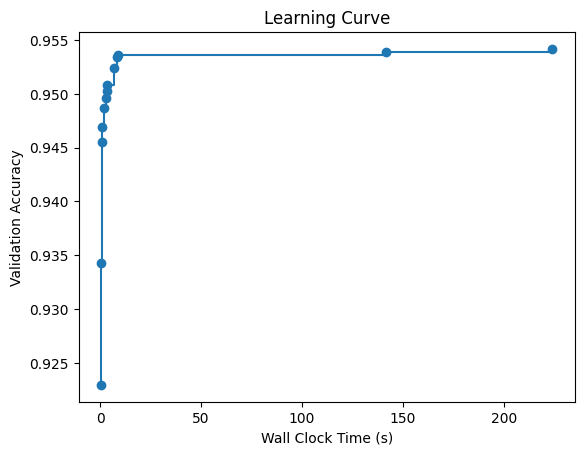

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()